In [298]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearnex import patch_sklearn, config_context

import pickle

from typing import Union

import tqdm

In [299]:
patch_sklearn()

The data set represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

In [300]:
DIABETIC_DATA = "../data/diabetic_data.csv"

In [301]:
df = pd.read_csv(DIABETIC_DATA)
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [302]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

so many fucking ? instead of NA

In [304]:
df.replace("?", np.nan, inplace=True)

In [305]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

don't care about these at all, the rest are important i guess so we use imputing

In [306]:
df.drop(columns=["max_glu_serum", "A1Cresult", "payer_code", "weight"], inplace=True) # actually not needed since we will use pca
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone  

In [307]:
all_columns = df.select_dtypes(include=["object"]).columns.tolist()
ordinal_columns = ["age"]
label_columns = [col for col in all_columns if col not in ordinal_columns]

In [308]:
imputer = SimpleImputer(strategy="most_frequent")

for col in all_columns:
    df.loc[:, col] = imputer.fit_transform(df[col].values.reshape(-1, 1))

In [309]:
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazo

In [310]:
label_encoders: dict[str, LabelEncoder] = {}

# FIXME: i think it's working but it gives warning maybe use reshape or sth i dunno
import warnings
warnings.filterwarnings("ignore") 


for col in ordinal_columns:
    if ordinal_encoder is None:
        ordinal_encoder = LabelEncoder()
    df[col] = ordinal_encoder.fit_transform(df[[col]])

for col in label_columns:
    if label_encoders.get(col) is None:
        label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[[col]])

In [311]:
df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,2,0,0.0,6,25,1,1,37,...,0,1,1,0,0,0,0,1,0,2
1,149190,55629189,2,0,1.0,1,1,7,3,18,...,0,3,1,0,0,0,0,0,1,1
2,64410,86047875,0,0,2.0,1,1,7,2,18,...,0,1,1,0,0,0,0,1,1,2
3,500364,82442376,2,1,3.0,1,1,7,2,18,...,0,3,1,0,0,0,0,0,1,2
4,16680,42519267,2,1,4.0,1,1,7,1,18,...,0,2,1,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,0,1,7.0,1,3,7,3,18,...,0,0,1,0,0,0,0,0,1,1
101762,443847782,74694222,0,0,8.0,1,4,5,5,18,...,0,2,1,0,0,0,0,1,1,2
101763,443854148,41088789,2,1,7.0,1,1,7,1,18,...,0,0,1,0,0,0,0,0,1,2
101764,443857166,31693671,2,0,8.0,2,3,7,10,62,...,0,3,1,0,0,0,0,0,1,2


In [312]:
df.drop_duplicates(inplace=True)

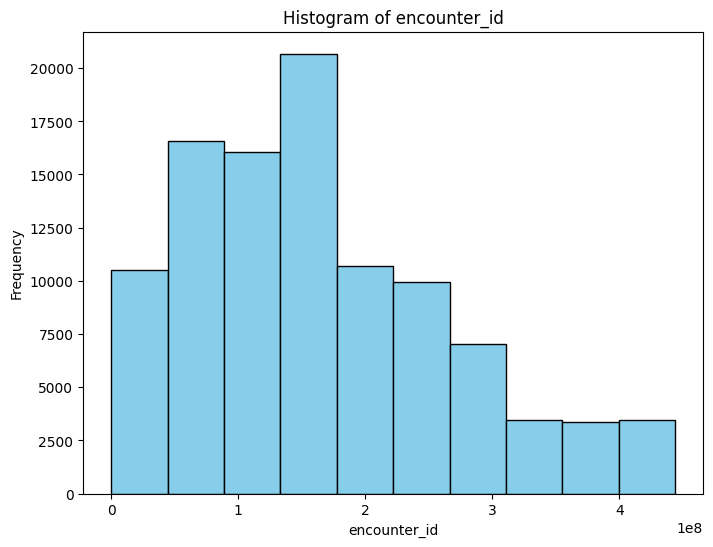

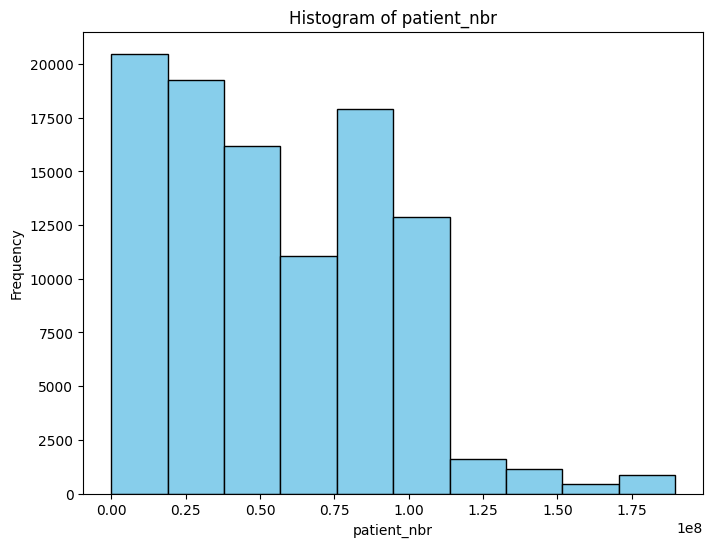

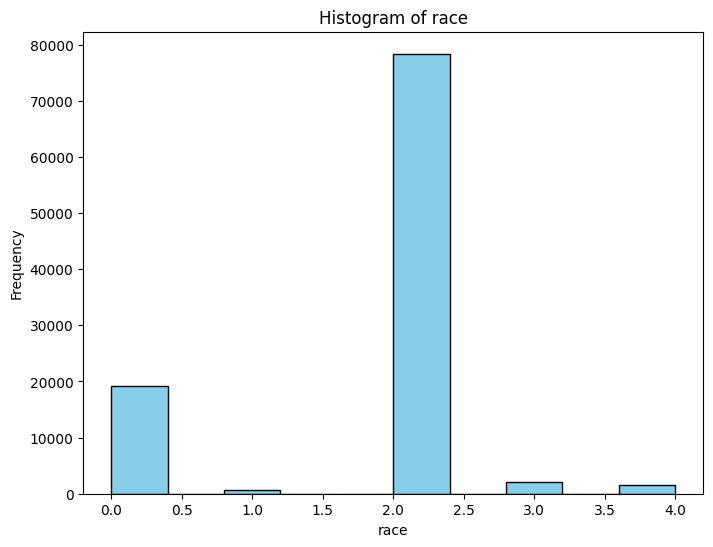

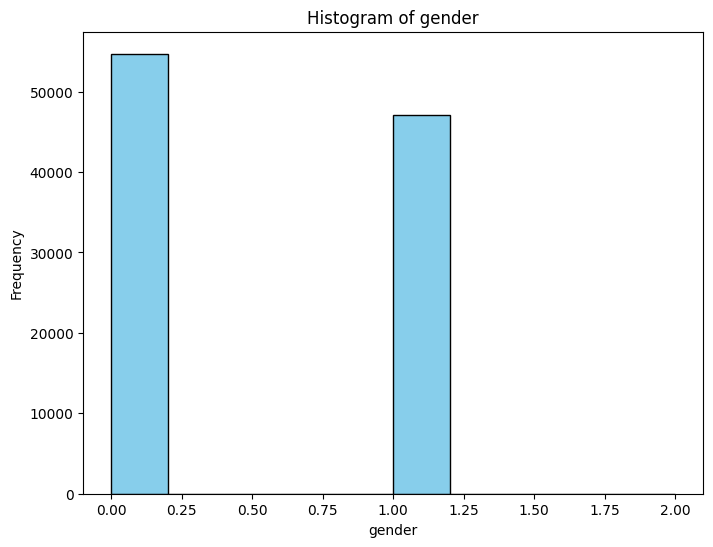

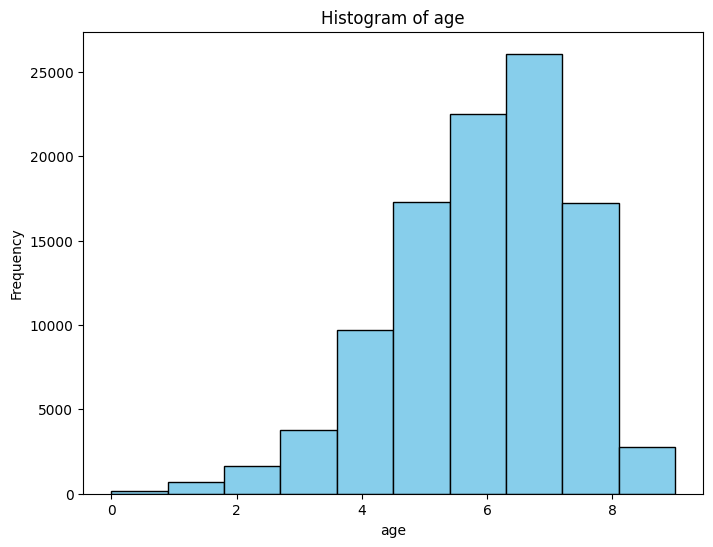

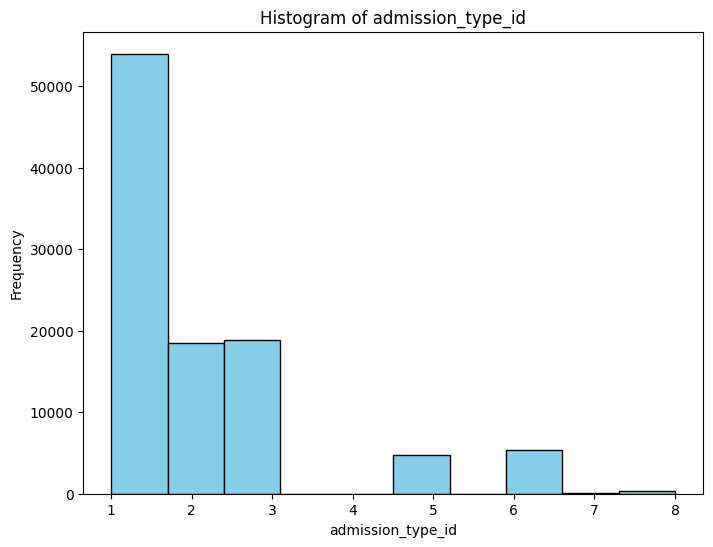

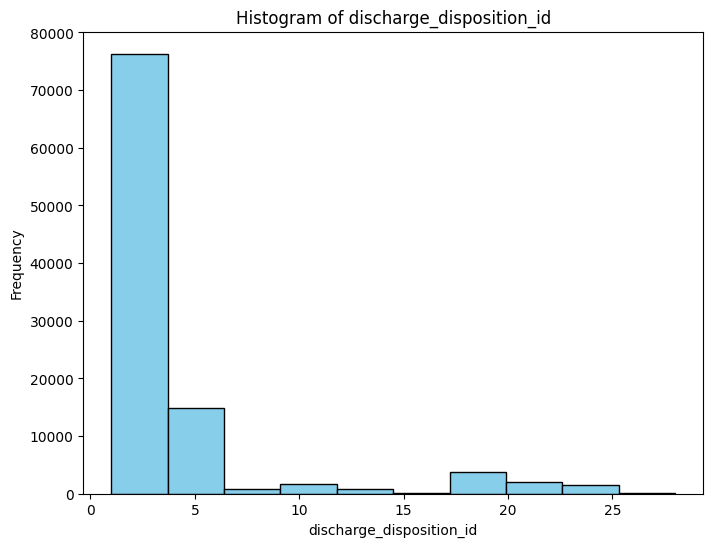

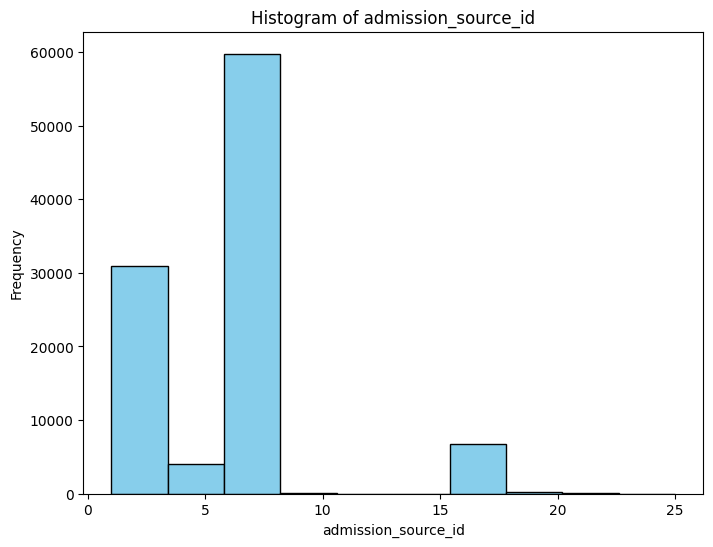

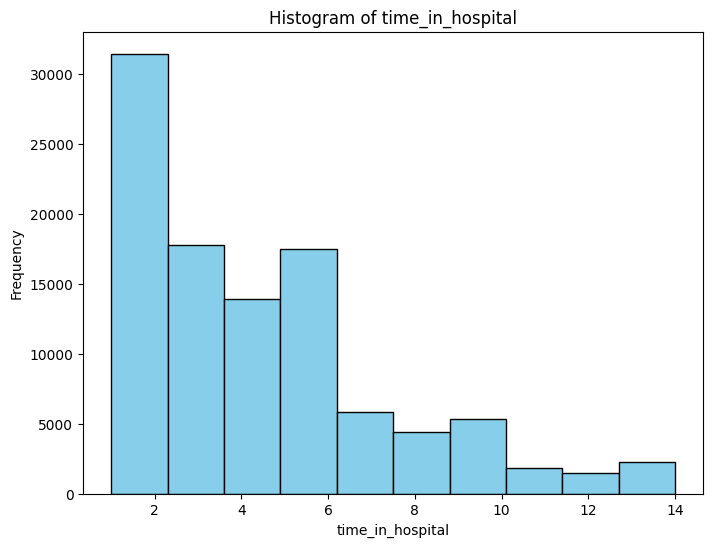

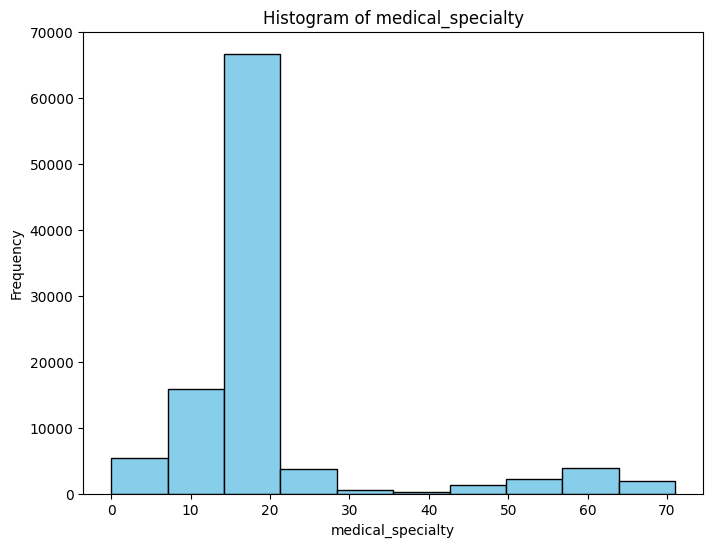

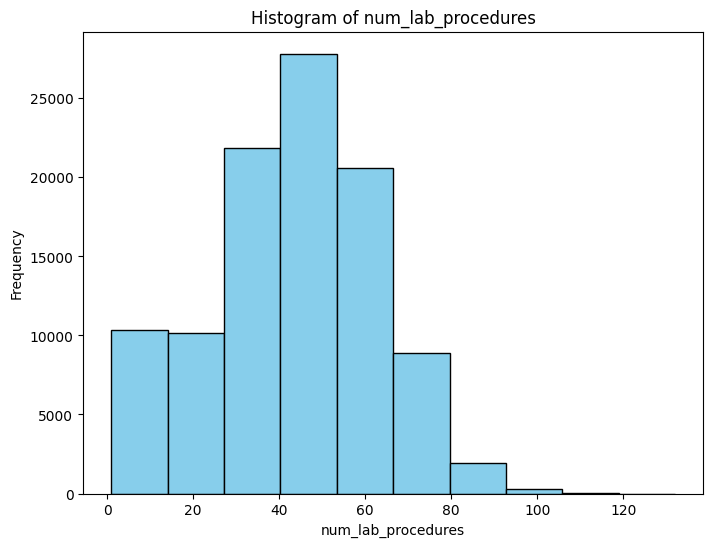

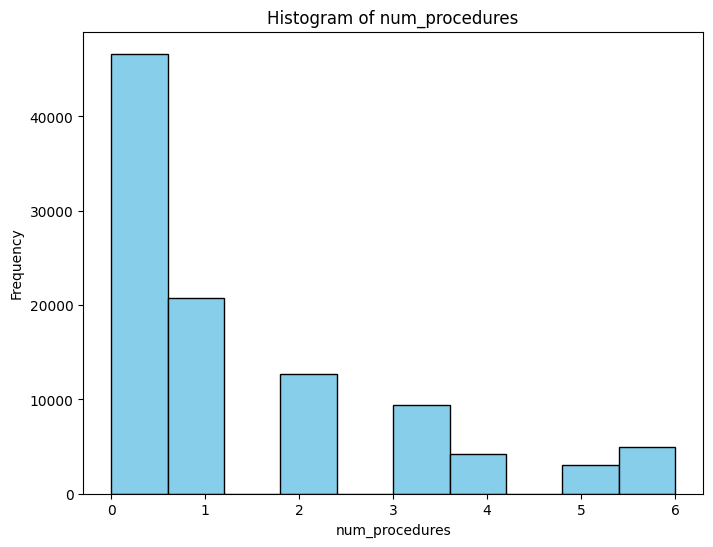

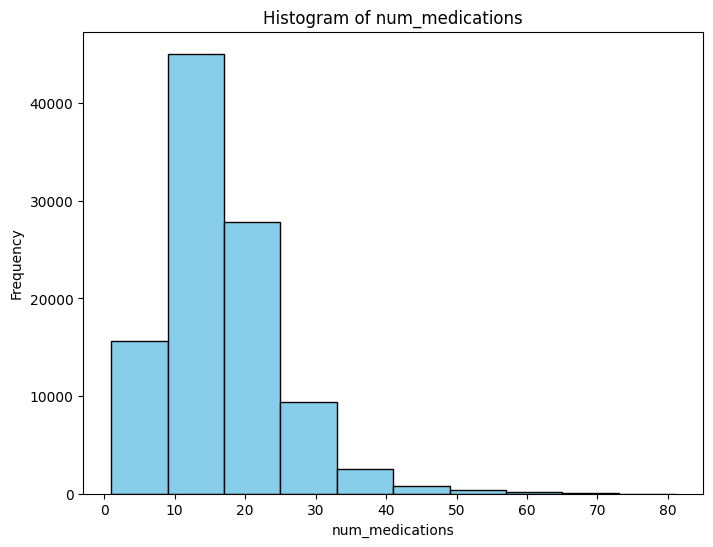

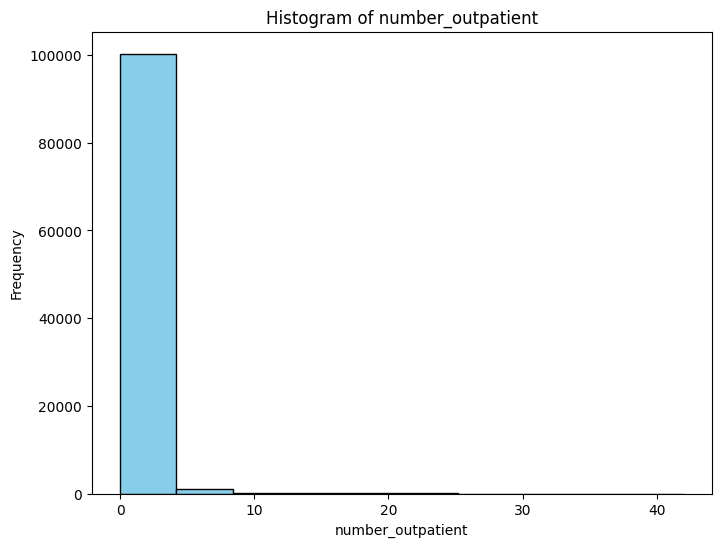

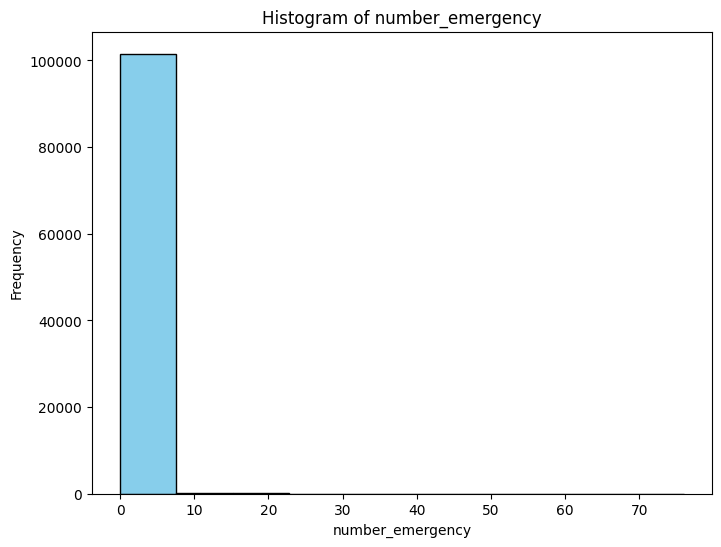

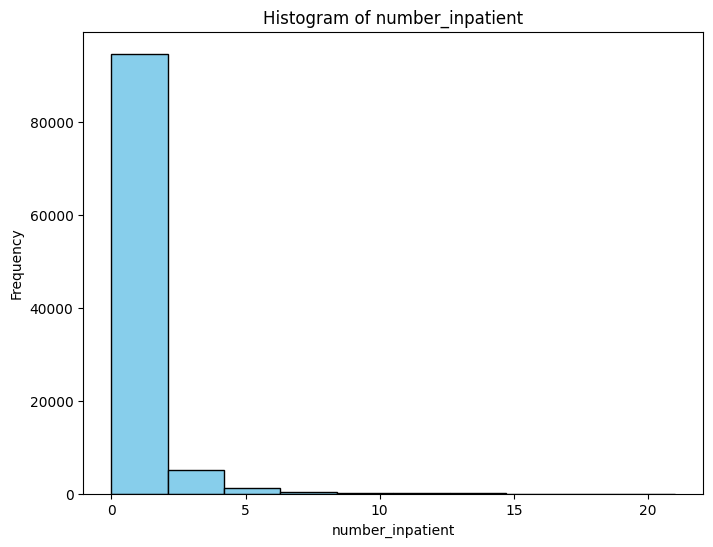

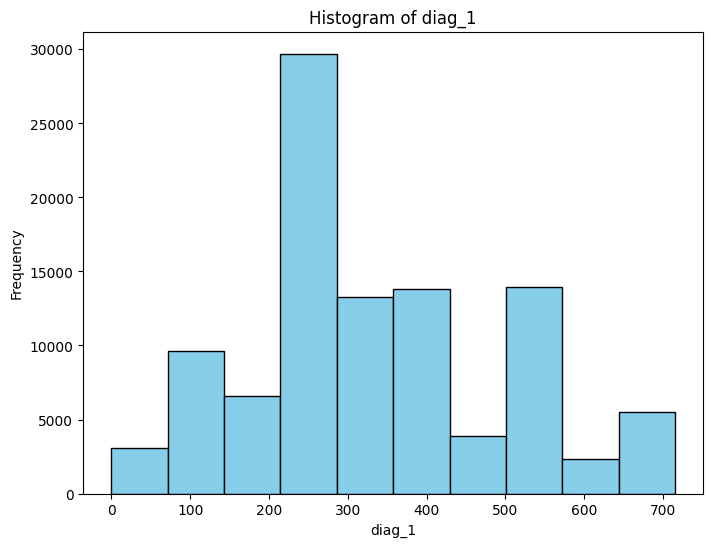

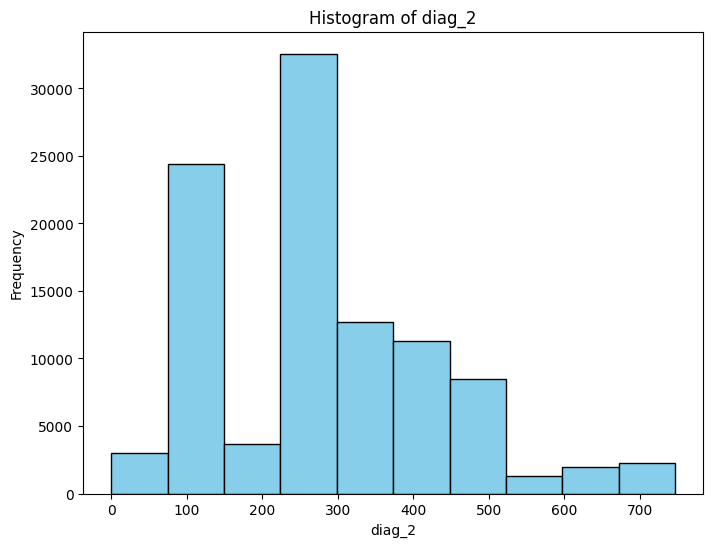

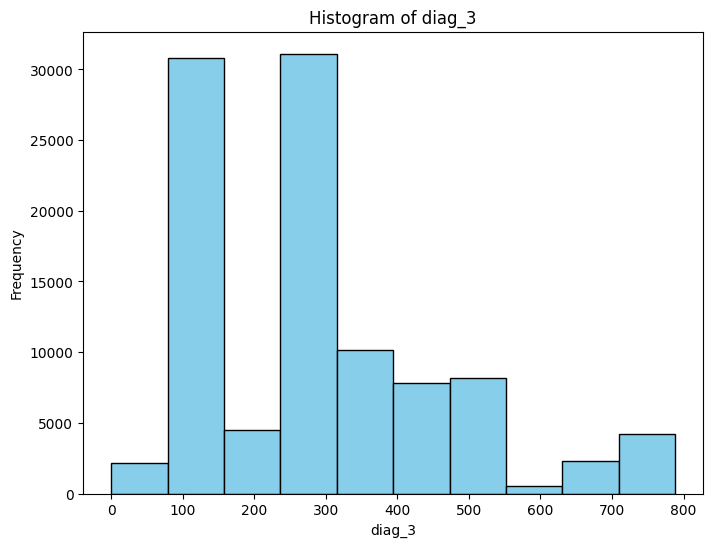

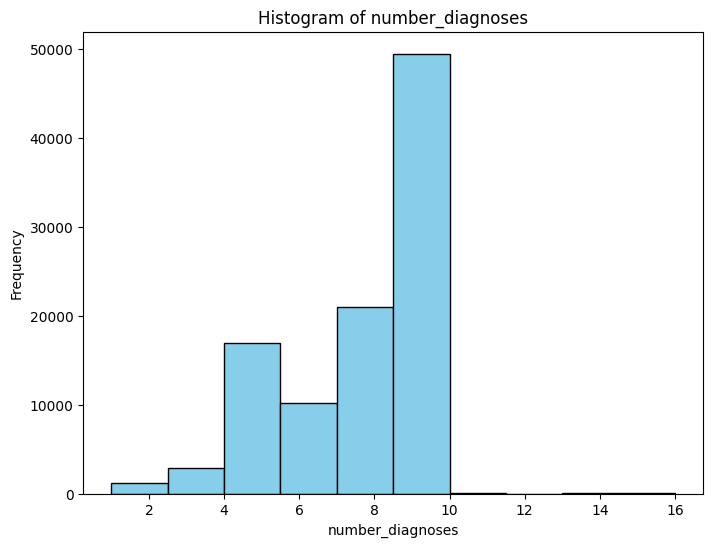

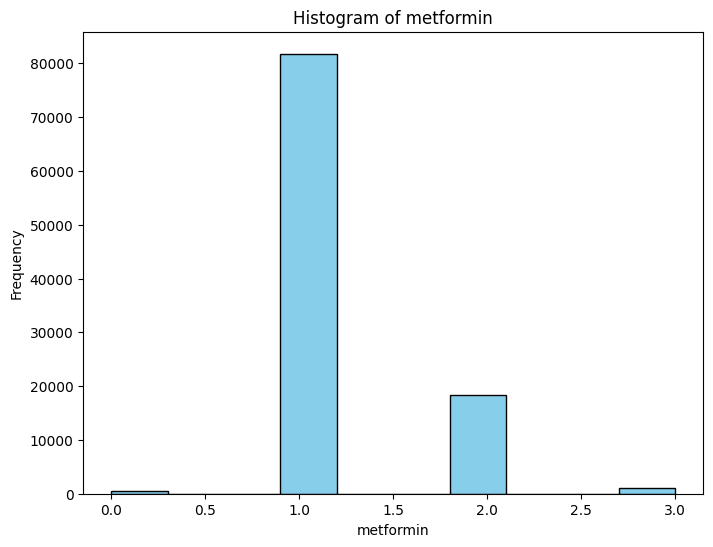

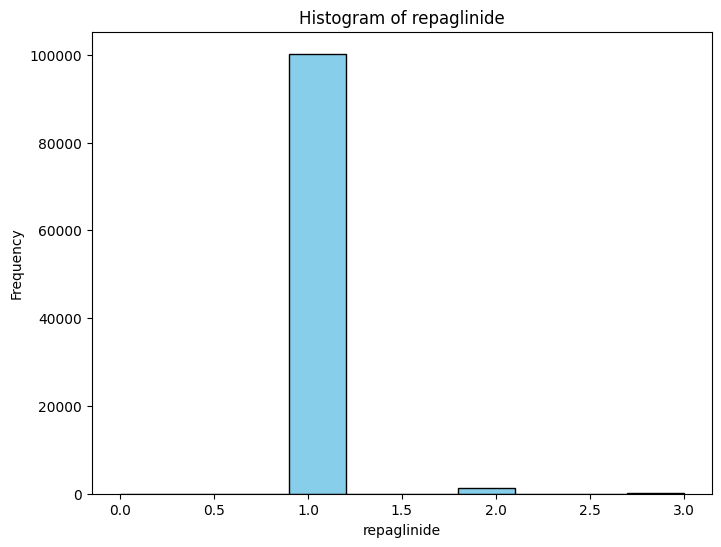

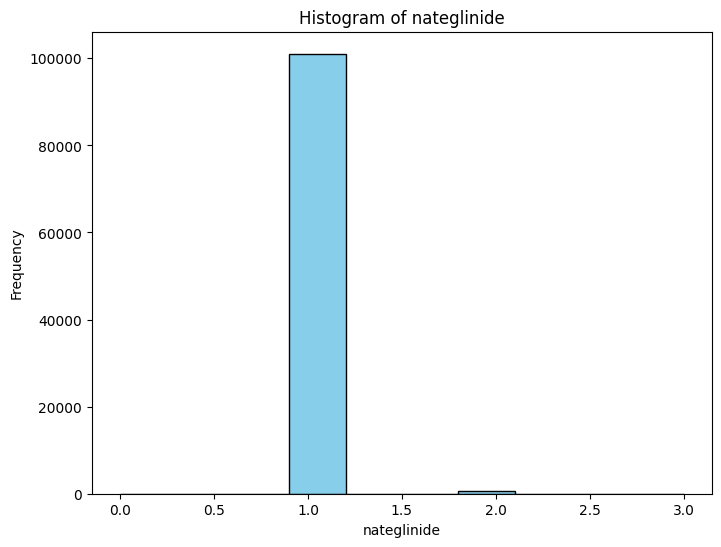

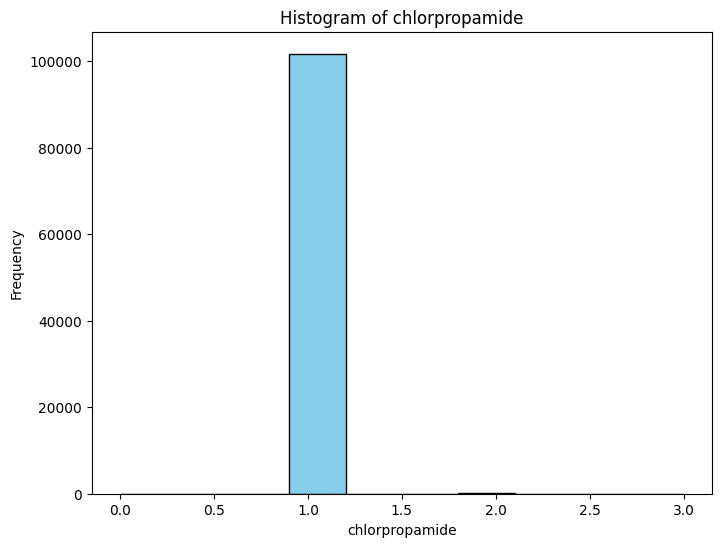

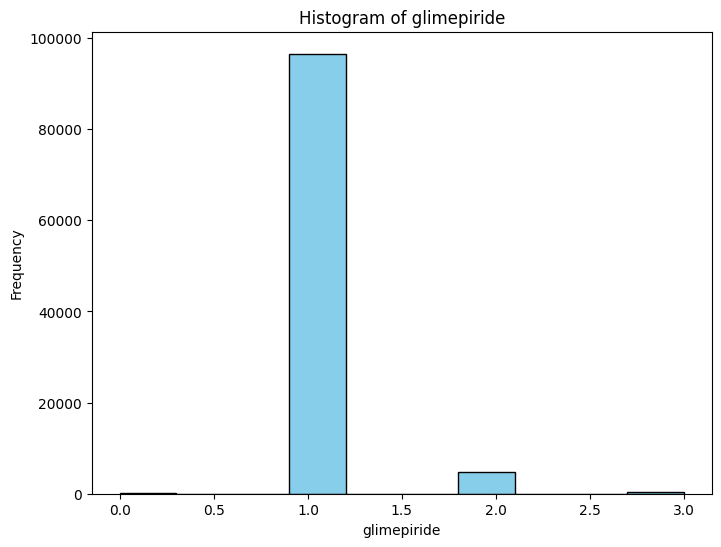

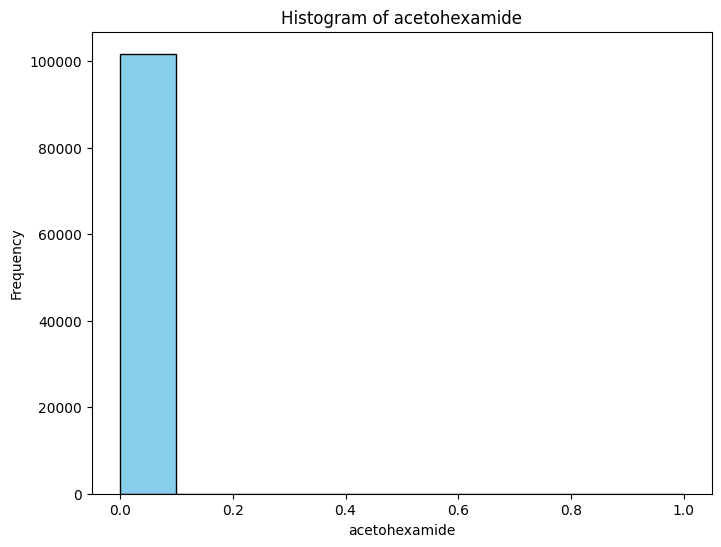

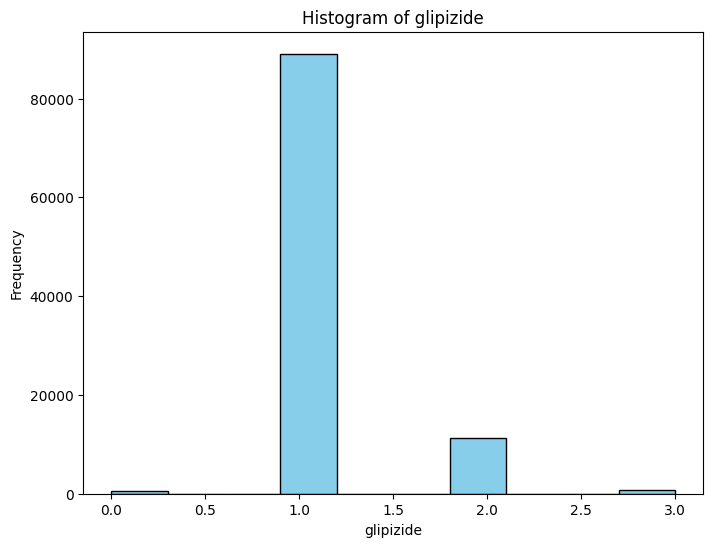

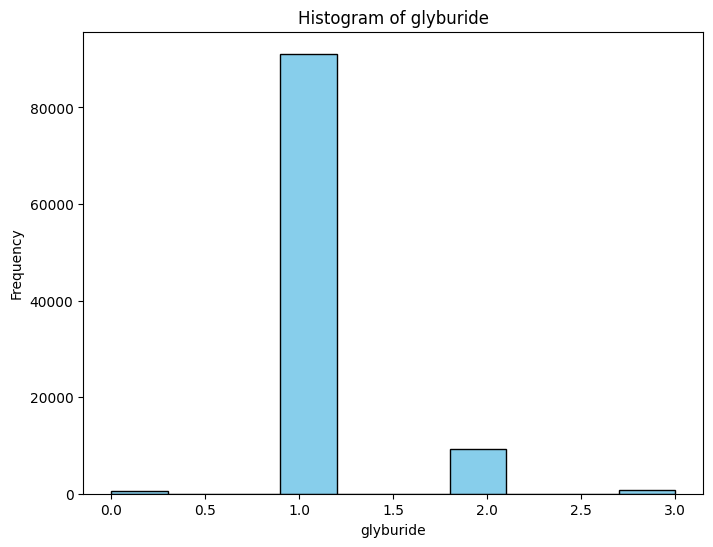

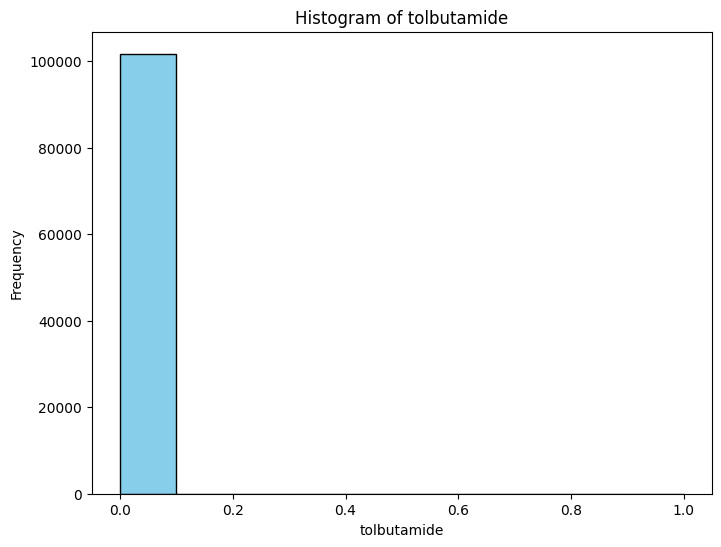

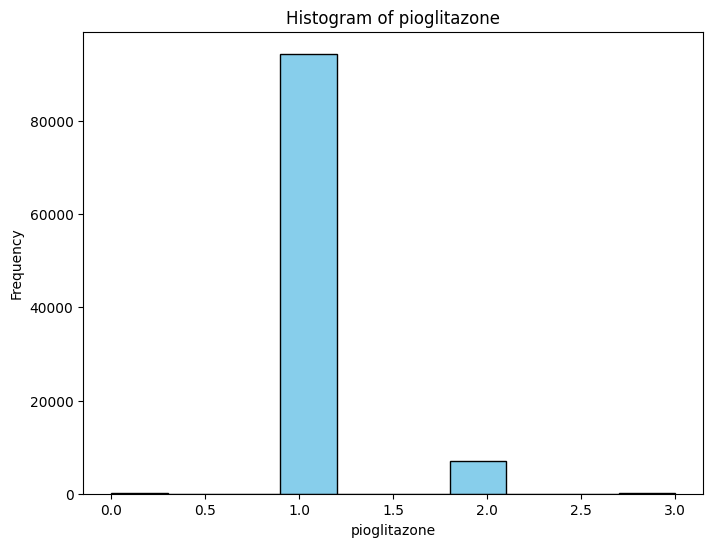

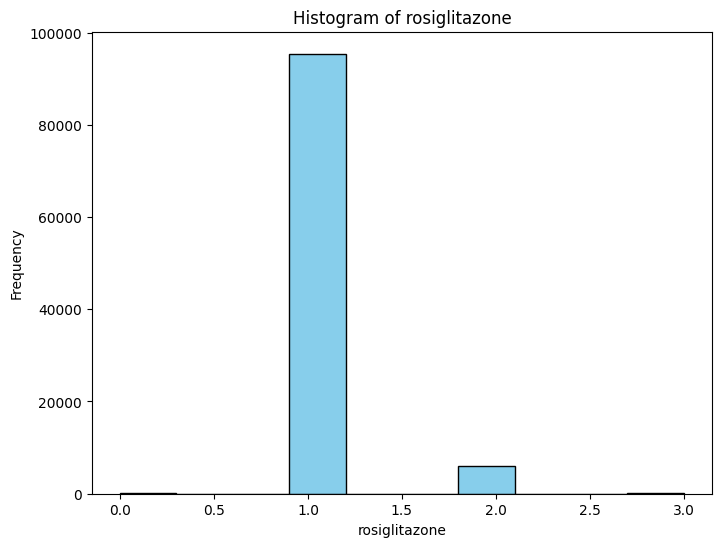

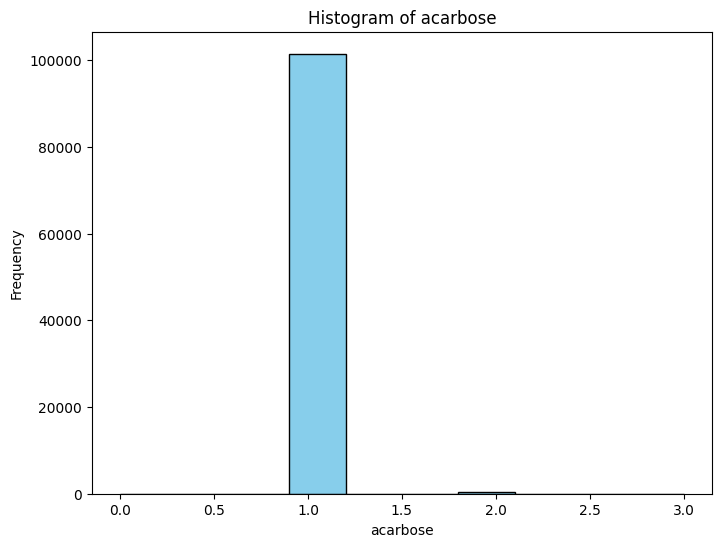

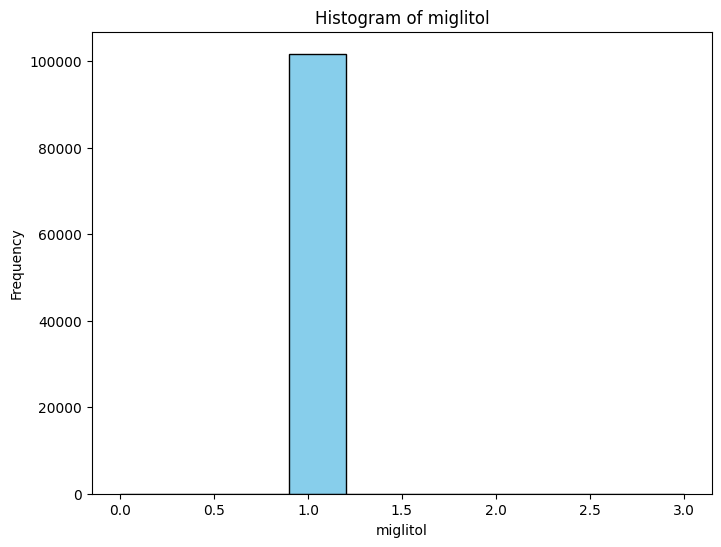

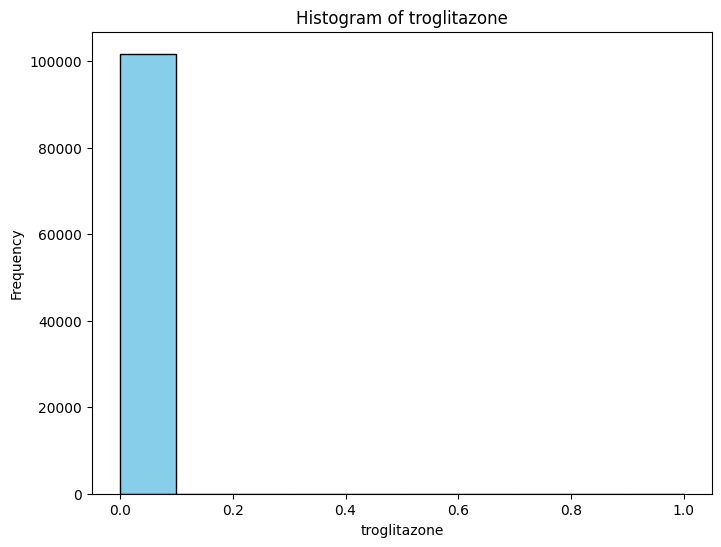

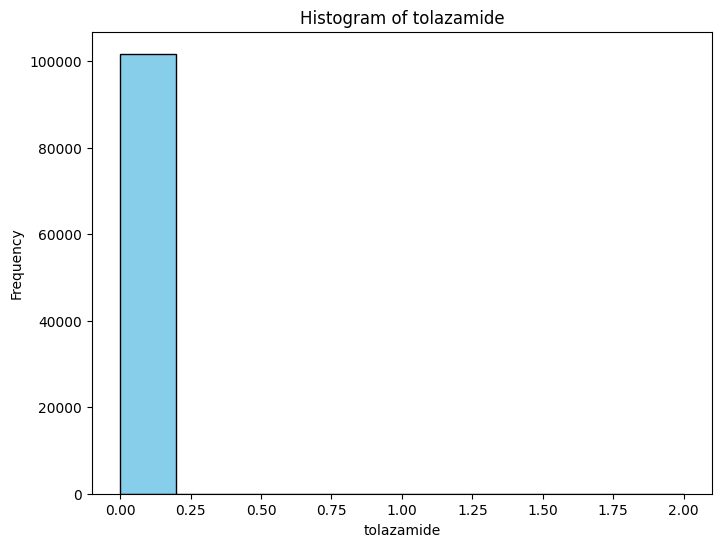

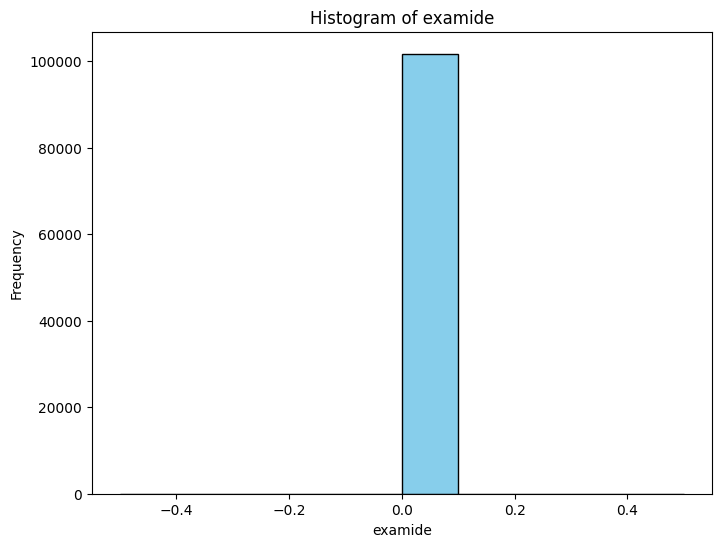

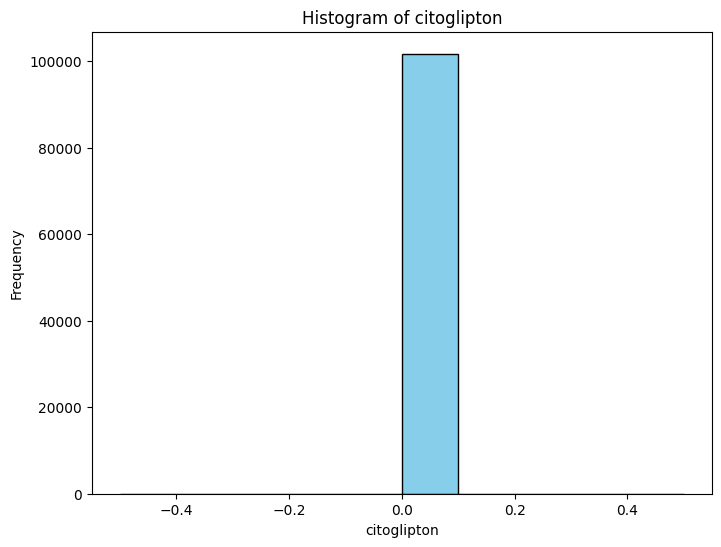

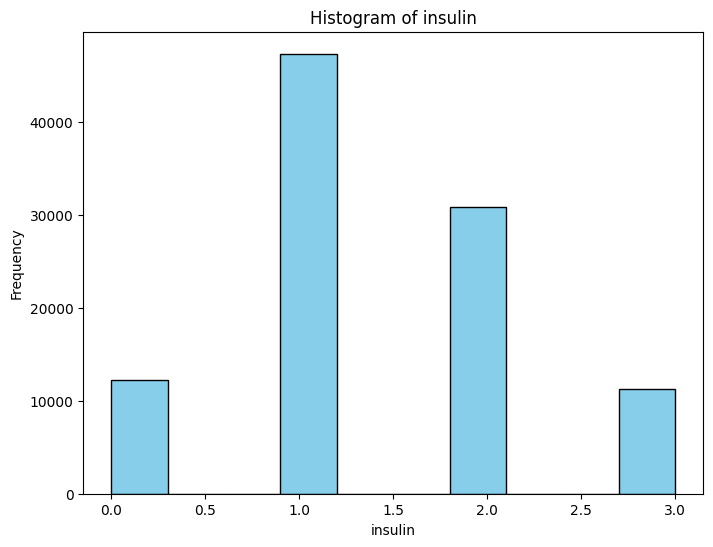

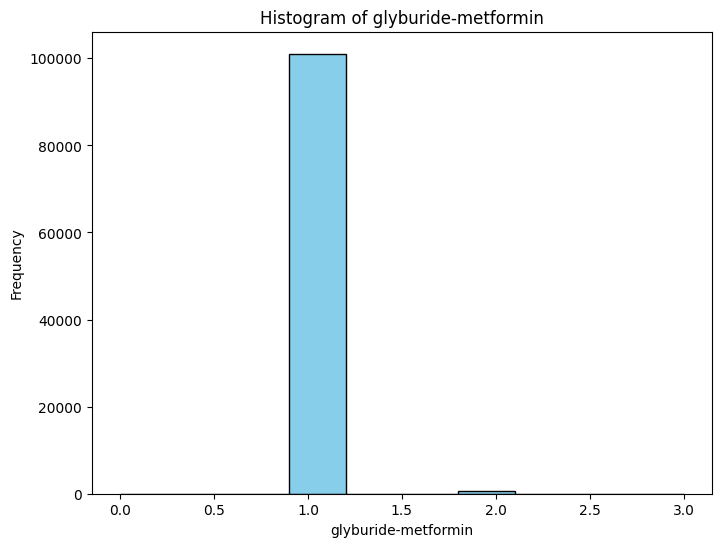

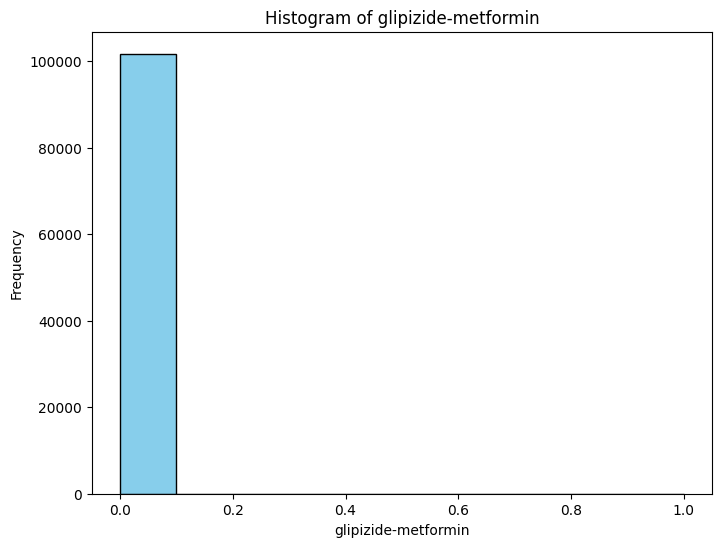

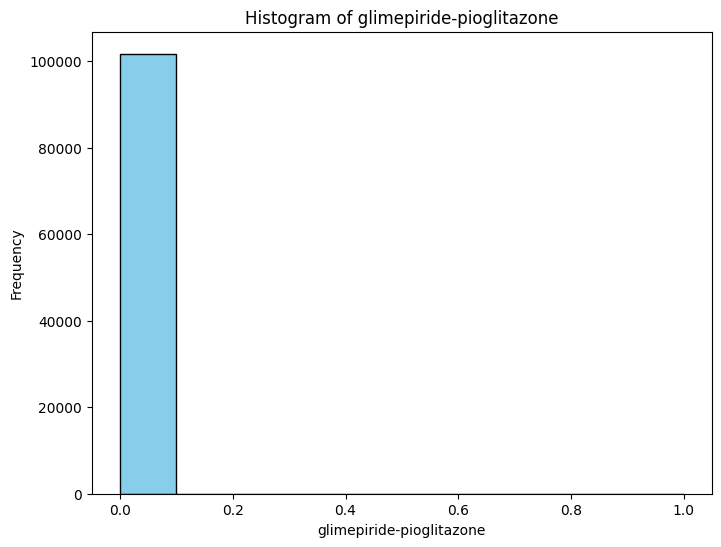

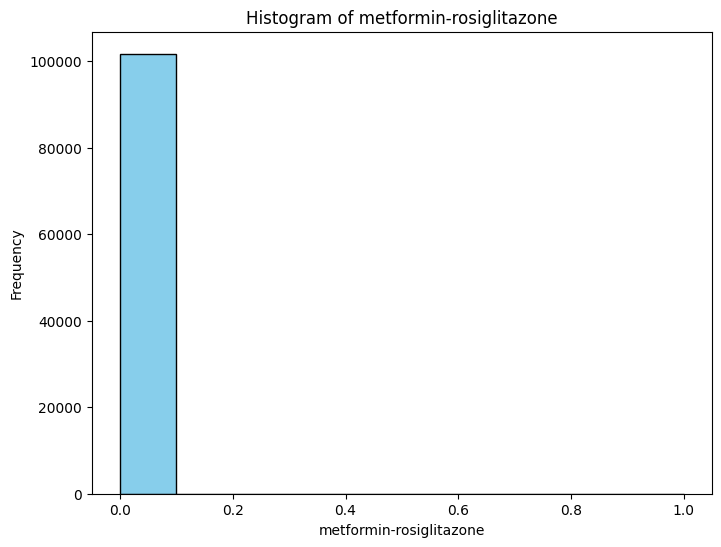

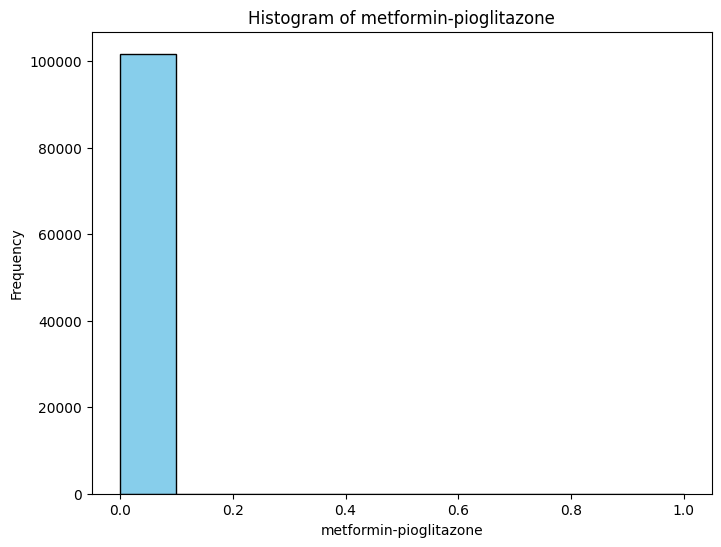

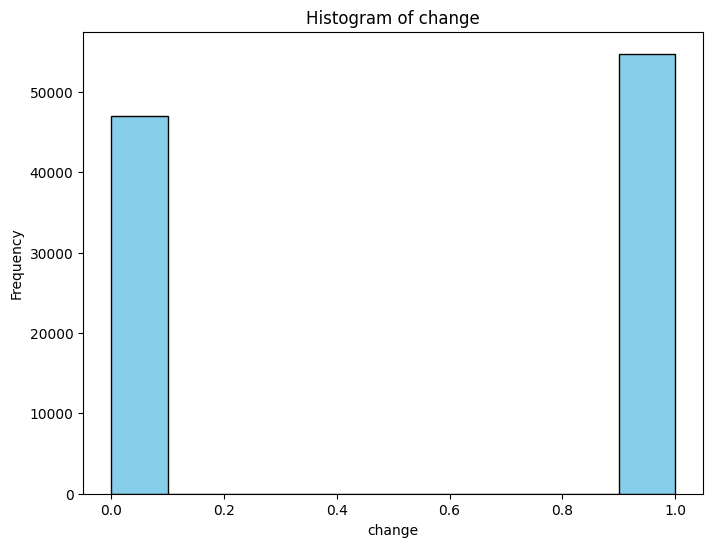

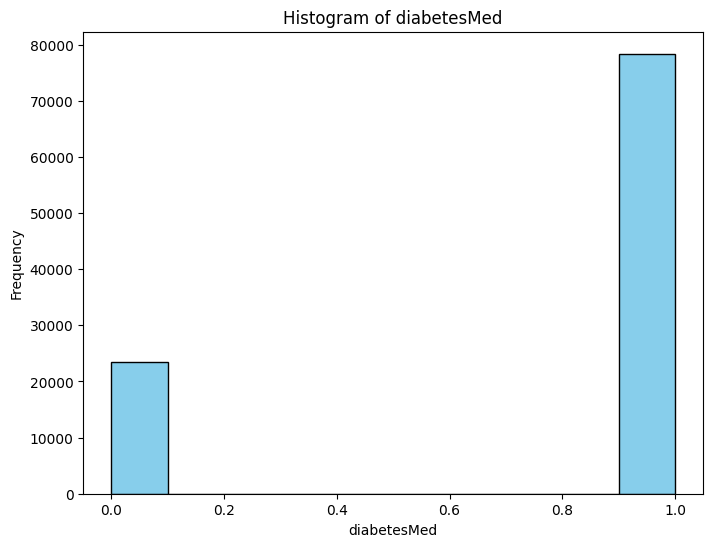

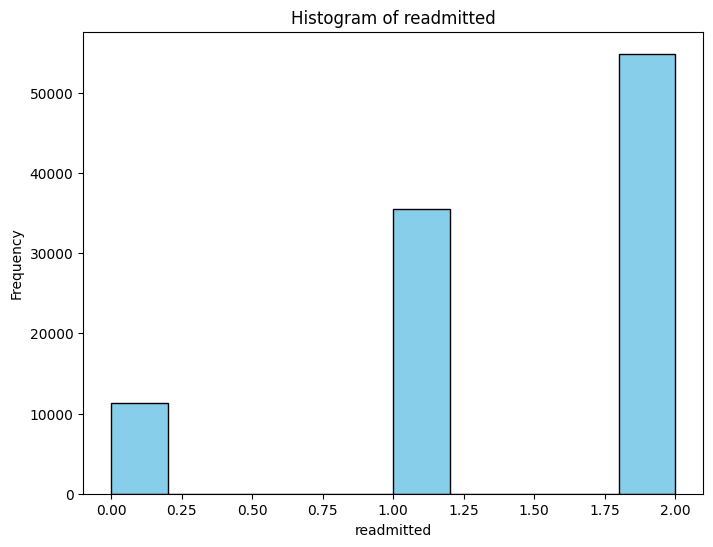

In [313]:
for col in df.columns:
    if df[col].dtype == "object": 
        plt.figure(figsize=(8, 6))
        df[col].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
        plt.title(f"Bar Plot of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(False)
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        df[col].hist(color="skyblue", edgecolor="black")
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(False)
        plt.show()
    

In [314]:
def delete_outliers(df: pd.DataFrame, columns: list[str], threshold: float) -> pd.DataFrame:
    clf = IsolationForest(contamination=threshold)
    outliers = clf.fit_predict(df[columns])
    return df.loc[outliers == 1]

In [315]:
df = delete_outliers(df, df.select_dtypes(include=["int64", "float64"]).columns.tolist(), 0.1)

In [316]:
X = df

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [317]:
pca.explained_variance_ratio_

array([0.24806858, 0.08586108, 0.07894487, 0.05941165, 0.0557533 ,
       0.04932934, 0.04690538, 0.03998024, 0.03885719, 0.03504838])

In [318]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: 0.7381600073949377


In [319]:
kmean_params = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "init": ["k-means++"],
}

kmean_grid = ParameterGrid(kmean_params)

In [ ]:
silhouette_scores = []

for params in tqdm.tqdm(kmean_grid):
    with config_context(target_offload="gpu:0"):
        kmeans = KMeans(**params)
        kmeans.fit(X_pca)
        labels = kmeans.labels_
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)
    
best_params = list(kmean_grid)[np.argmax(silhouette_scores)]

In [321]:
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {np.max(silhouette_scores)}")

Best Parameters: {'init': 'k-means++', 'n_clusters': 2}
Best Silhouette Score: 0.2820480771440175


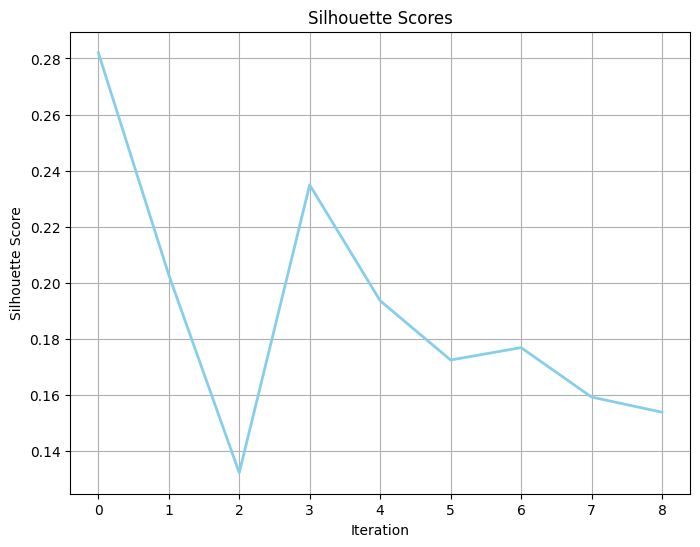

In [322]:
plt.figure(figsize=(8, 6))
plt.plot(silhouette_scores, color="skyblue", lw=2)
plt.title("Silhouette Scores")
plt.xlabel("Iteration")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [323]:
best_kmeans = KMeans(**best_params)
best_kmeans.fit(X_pca)

KMeans(n_clusters=2)

In [324]:
with open("../models/best_kmeans.pkl", "wb") as f:
    pickle.dump(best_kmeans, f)

In [325]:
db_params = {
    "eps": [0.1, 0.2, 0.3, 0.4, 0.5],
    "min_samples": [5, 10, 20, 25],
}

db_grid = ParameterGrid(db_params)

In [ ]:
silhouette_scores = []

for params in tqdm.tqdm(db_grid):
    with config_context(target_offload="gpu:0"):
        db = DBSCAN(**params)
        db.fit(X_pca)
        labels = db.labels_
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)
    
best_params = list(db_grid)[np.argmax(silhouette_scores)]

In [327]:
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {np.max(silhouette_scores)}")

Best Parameters: {'eps': 0.5, 'min_samples': 5}
Best Silhouette Score: 0.2891408988122001


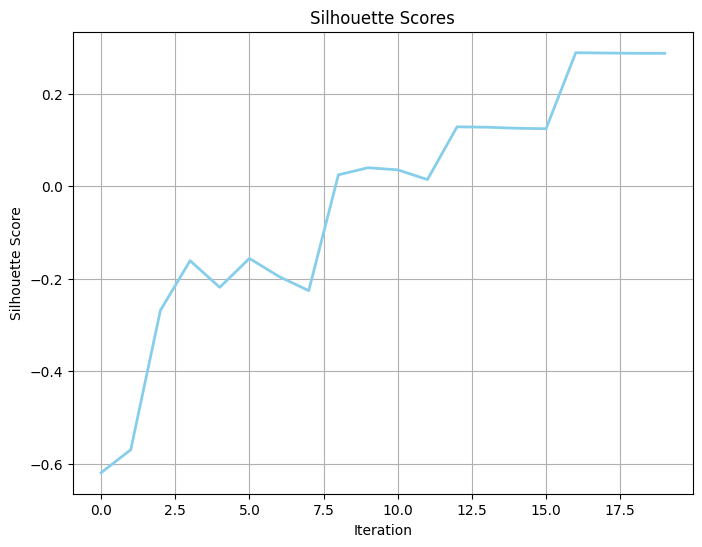

In [328]:
plt.figure(figsize=(8, 6))
plt.plot(silhouette_scores, color="skyblue", lw=2)
plt.title("Silhouette Scores")
plt.xlabel("Iteration")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [329]:
best_db = DBSCAN(**best_params)
best_db.fit(X_pca)

DBSCAN()

In [330]:
with open("../models/best_db.pkl", "wb") as f:
    pickle.dump(best_db, f)

In [339]:
with open("../models/best_kmeans.pkl", "rb") as f:
    best_kmeans = pickle.load(f)
    
with open("../models/best_db.pkl", "rb") as f:
    best_db = pickle.load(f)

In [340]:
with open("../result/result.csv", "w") as f:
    kmeans_labels = best_kmeans.labels_
    db_labels = best_db.labels_
    f.write("id_encounter,kmeans_label,dbscan_label\n")
    ids = df["encounter_id"].values
    for i in range(len(ids)):
        f.write(f"{ids[i]},{kmeans_labels[i]},{db_labels[i]}\n")

TODO: Add visualization and shit (k-distance 3d and more, not sure which of them is applicable here)

FUCK YOU STUPID TA
1. Preprocessing: replacing ? with NA, removing duplication, handling the missing values with mode and shits, scaling
2. 10 parts since the usual .95 percent was keeping too many features which kinda beats the purpose, the values here are quite good and enough 
3. okey dokey
4. thats the whole fucking thing we did using that motherfucker silhouette, but there are other metrics to analyze which i'm too tired to search for 
5. FUCK U
6. [meow](https://towardsdatascience.com/k-means-vs-dbscan-clustering-49f8e627de27) 
and this is from GPT  


K-Means and DBSCAN are both popular clustering algorithms, but they have different strengths and weaknesses, making them suitable for different scenarios. Here are some guidelines on when to use each:

### When to Use K-Means

1. **Well-Separated Clusters**: Use K-Means when you have data that is well-separated into distinct clusters.
2. **Spherical Clusters**: K-Means works well when clusters are roughly spherical (i.e., clusters are shaped like balls in multi-dimensional space).
3. **Scalability**: K-Means is computationally efficient and scales well to large datasets, making it suitable for big data applications.
4. **Easy to Implement**: If you need a straightforward and easy-to-implement algorithm, K-Means is a good choice.
5. **Fixed Number of Clusters**: K-Means requires you to specify the number of clusters (K) beforehand. Use it when you have a good estimate or prior knowledge of the number of clusters in your data.
6. **Sensitivity to Initialization**: K-Means is suitable when you can handle its sensitivity to initial centroids, possibly by using techniques like K-Means++ for better initialization.

### When to Use DBSCAN

1. **Arbitrary Shape Clusters**: DBSCAN is preferable when your clusters have arbitrary shapes, not necessarily spherical.
2. **Noise and Outliers**: Use DBSCAN if your data contains noise and outliers, as it can effectively identify and handle them by marking them as noise.
3. **Density-Based Clustering**: DBSCAN is ideal when you expect clusters to be defined by high-density regions. It can find clusters of varying densities, which is a limitation of K-Means.
4. **No Need for Pre-Specifying Number of Clusters**: DBSCAN does not require specifying the number of clusters beforehand. It determines the number of clusters based on the data and the density parameters.
5. **Small to Medium Datasets**: While DBSCAN can be computationally more expensive and may not scale as well as K-Means for very large datasets, it is suitable for small to medium-sized datasets.
6. **Parameter Sensitivity**: DBSCAN requires careful tuning of parameters like the radius for the neighborhood (`eps`) and the minimum number of points (`minPts`). It is useful when you can invest the effort to fine-tune these parameters for better clustering results.

### Summary

- **K-Means** is suitable for large datasets with well-separated, spherical clusters and when you can pre-specify the number of clusters.
- **DBSCAN** is better for data with arbitrary-shaped clusters, containing noise and outliers, and where the number of clusters is not known beforehand or varies based on density.

Choosing between K-Means and DBSCAN depends on the nature of your data and the specific requirements of your clustering task.